<a href="https://colab.research.google.com/github/ColstonBod-oy/CCS7-TensorFlowDemos/blob/main/models/classification/CCS7_Classification_Model_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using TensorFlow to solve a Classification Problem**
This activity looks at how Classification Models are utilized to process a given set of data and classify them. For this activity, we will be looking at how we can do classification with the TensforFlow tools. We will also be looking at how a general machine learning workflow is done as well as how classifcation concepts are applied in practice. Make sure to set up and run the sample code then analyze the different components and how they work.

**Each of the guide questions must be answered in 100 to 200 words each.**

**Make sure to click "File" and then "Save a Copy in Drive" before making any changes to the demo.**

# **Preparing the tools and libraries**

**Importing the TensorFlow data and other libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**We start by downloading and exploring the dataset**

We will be making use of a dataset containing 3,700 photos of flowers. There are five types of flowers in the dataset:
*   Daisy
*   Dandelion
*   Roses
*   Sunflowers
*   Tulips

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 3s 0us/step


We can check the number of images by using the given code below.

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


We can then view the different images by using the given code below.

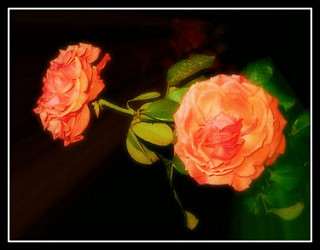

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

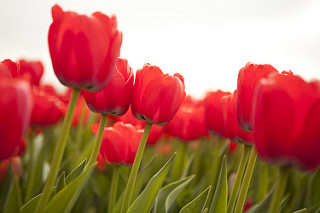

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[5]))

# **Creating our dataset**

We start our classification process by defining some parameters for the loader.

In [6]:
batch_size = 32
img_height = 180
img_width = 180

We then do a validation split for the model, with 80% of the images used for training, and 20% for validation.

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


We can then check the class names for these datasets to see what classes we are working with.

In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# **Preparing our dataset**

We will now configure our dataset to be fed to the model by configuring and standardizing the data.

We start of by configuring the dataset for performance, allowing us to process data faster and more efficiently.

*   **Guide Question 1:** Why do we use **Dataset.cache** for our data? What does it do and how does it help? What happens if we dont use this?
*   **Guide Question 2:** What is **Dataset.prefetch** and what is it used for? How does it help with preparing our dataset and what will happen if this code is removed?

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

We now standardize our data. This is done by adjusting the RGB values for the given images. Currently, the RGB values are in the [0, 255] range and we want to standardize them to be in the [0, 1] range.

In [11]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# **Creating the Model**

We will then create the model that we will be using for classification. For this code, we will be using the Sequential model.

*   **Guide Question 3:** What are other models that we can use for machine learning in the **Tensorflow** platform? Kindly look for at least 3 others and give a brief description for each.



In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

We then compile our model using the given code below. This will allow us to record the training and validation accuracy for each epoch and record the data.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

We can then view the layers of our model using the code below.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# **Training the Model**

We then train our model using the given code below. If you recall, epochs are used to denote how many complete pass throughs will be done for the data. In this case, we will set the value to **10** initially, but feel free to change it later to see how it works.

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 114s 1s/step - loss: 1.4165 - accuracy: 0.4220 - val_loss: 1.1111 - val_accuracy: 0.5504
Epoch 2/10
92/92 [==============================] - 110s 1s/step - loss: 1.0431 - accuracy: 0.5920 - val_loss: 1.0465 - val_accuracy: 0.5790
Epoch 3/10
92/92 [==============================] - 107s 1s/step - loss: 0.8530 - accuracy: 0.6812 - val_loss: 1.0557 - val_accuracy: 0.6022
Epoch 4/10
92/92 [==============================] - 107s 1s/step - loss: 0.6320 - accuracy: 0.7691 - val_loss: 1.0700 - val_accuracy: 0.6063
Epoch 5/10
92/92 [==============================] - 110s 1s/step - loss: 0.4380 - accuracy: 0.8460 - val_loss: 1.1608 - val_accuracy: 0.6213
Epoch 6/10
92/92 [==============================] - 112s 1s/step - loss: 0.2682 - accuracy: 0.9121 - val_loss: 1.3401 - val_accuracy: 0.6199
Epoch 7/10
92/92 [==============================] - 109s 1s/step - loss: 0.1634 - accuracy: 0.9441 - val_loss: 1.4992 - val_accuracy: 0.6131
Epoch 8/10
92

We can then visualize our results to see how well our model did during the training and validation.
*   **Guide Question 4:** What does the **training and validation accuracy** (sometimes called test accuracy) mean? What do these values mean if they are high or low? Why is the validation accuracy generally lower than the training accuracy?
*   **Guide Question 5:** Based on your own understanding, why does the graphs below indicate a problem of overfitting for our model?

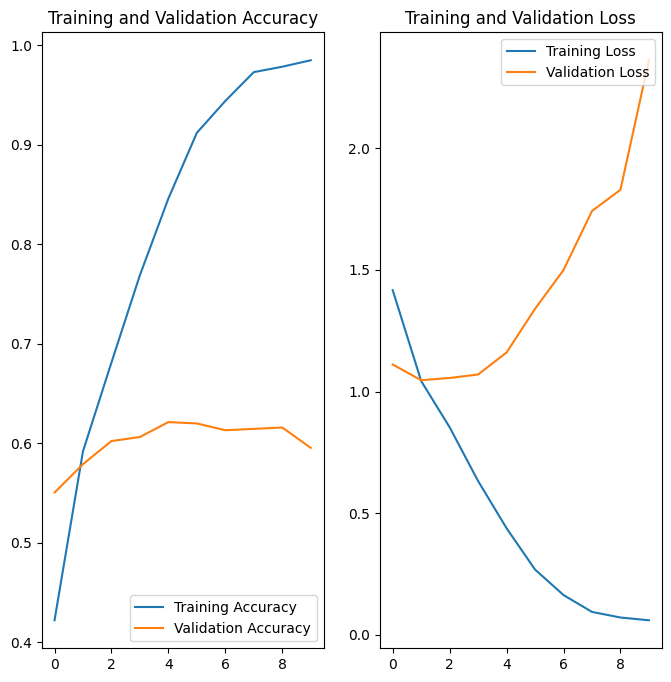

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Fixing Overfitting**

As seen in our results, our model was successfully trained, but has an issue of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. 

This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are two ways that we will be addressing the issue of overfitting. We will be looking at **data augmentation** and adding **droput** to the model.

# **Data Augmentation**

We will make use of data augmentation in order for us to be able to get more accurate results from our model. We will make use of Keras for this purpose, with the code below applying data augmentation, which runs on the GPU.
*   **Guide Question 6:** What is **data augmentation** and what is it used for? How will data augmentation affect our data?
*   **Guide Question 7:** What are **ten (10)** examples of data augmentation?

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.99),
    layers.RandomZoom(0.99),
    layers.RandomCrop(99, 99),
    layers.RandomContrast(0.99),
  ]
)

We can visualize the effect of augmentation by printing one of the images from our dataset along with the augmented versions of it.

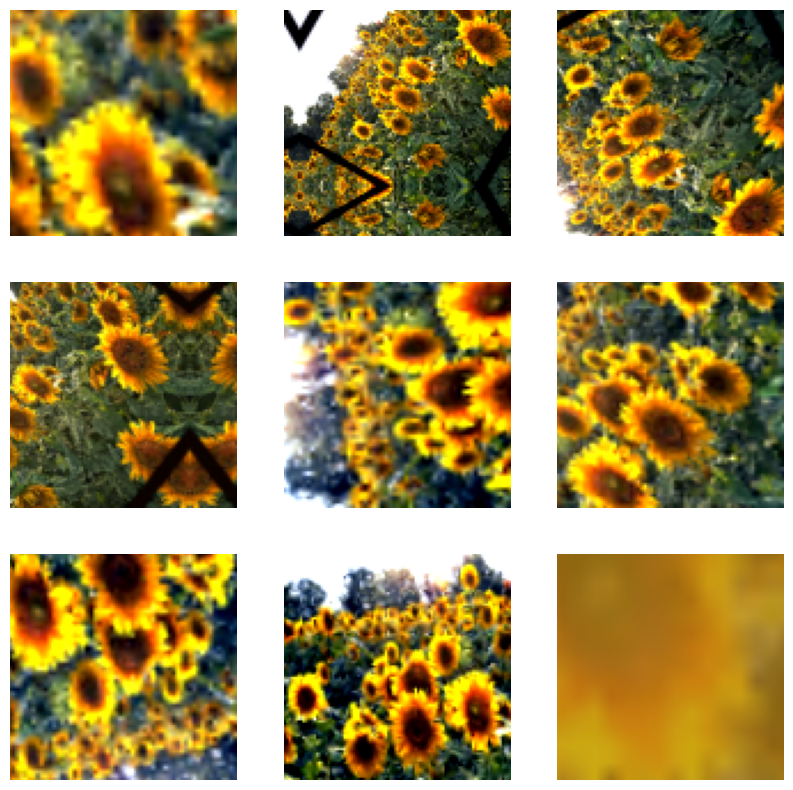

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# **Dropout**

We will also make use of dropout, which is another technique to address overfitting in our model and is mainly used with neural network type models.
*   **Guide Question 8:** What is **dropout** and how is it used in machine learning? What does droput do to our model and how will it affect the model?

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# **Retraining the Model**

After applying these two tools to our data and model, we will then retrain the model to see how it fares in terms of its accuracy.

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Same as before, we can view the layers of our model using the code below.

In [26]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 99, 99, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 99, 99, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 99, 99, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 49, 49, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                  

We will train our model again, but this time, we will use **15** epochs instead of **10** to see if we can also get a better result by adjusting the epochs.

In [27]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 52s 532ms/step - loss: 1.4426 - accuracy: 0.3338 - val_loss: 1.3547 - val_accuracy: 0.3665
Epoch 2/15
92/92 [==============================] - 49s 532ms/step - loss: 1.3185 - accuracy: 0.4264 - val_loss: 1.2919 - val_accuracy: 0.4169
Epoch 3/15
92/92 [==============================] - 49s 538ms/step - loss: 1.3116 - accuracy: 0.4264 - val_loss: 1.2448 - val_accuracy: 0.4823
Epoch 4/15
92/92 [==============================] - 49s 533ms/step - loss: 1.2541 - accuracy: 0.4499 - val_loss: 1.1516 - val_accuracy: 0.5436
Epoch 5/15
92/92 [==============================] - 48s 520ms/step - loss: 1.2676 - accuracy: 0.4513 - val_loss: 1.1641 - val_accuracy: 0.5177
Epoch 6/15
92/92 [==============================] - 50s 543ms/step - loss: 1.2215 - accuracy: 0.4748 - val_loss: 1.0468 - val_accuracy: 0.5872
Epoch 7/15
92/92 [==============================] - 49s 534ms/step - loss: 1.2107 - accuracy: 0.5027 - val_loss: 1.0382 - val_accuracy: 0.5777

Let us now visualize our results to see how well our model did after our data was augmented and our model had dropout added?
*   **Guide Question 9:** Discuss the results of the second model output. Was the model more accurate or less accurate and why?
*   **Guide Question 10:** Do you think the accuracy of the model could be improved further with additional data augmentations?
*   **Guide Question 11:** Do you think that increasing or decreasing the droput rate of the model can improve its accuracy, and why?

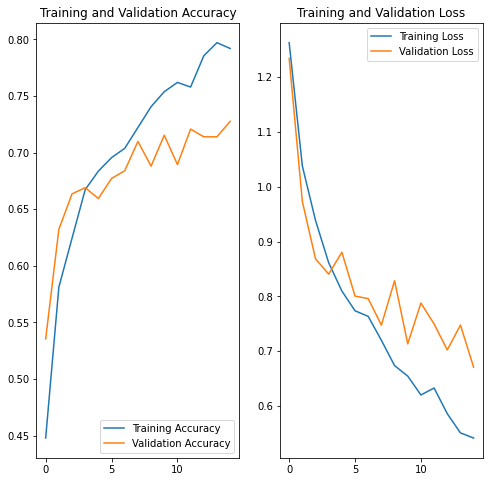

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Test the Model!**

Let us test out our model on a single image to see how it does. You can select images using the dataset below to test out how the model does when it tries to predict the flower type of a single image.

Dataset Samples: https://storage.googleapis.com/openimages/web/index.html

Just replace the "flower_url" with the URL of the image you would like to test and the "flower_path" data with the name of the image that you will be testing against the model.

In [30]:
flower_url = "https://c3.staticflickr.com/4/3910/14838471840_15877d3ae7_o.jpg"
flower_path = tf.keras.utils.get_file('14838471840_15877d3ae7_o', origin=flower_url)

img = tf.keras.utils.load_img(
    flower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 56ms/step
This image most likely belongs to sunflowers with a 68.02 percent confidence.
